In [34]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [35]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [36]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [37]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [28]:
# tn_era5 = xr.open_mfdataset('%s/daily/tasmin_*.nc'%dirEra5)
# tn_era5 = tn_era5.sel(time=slice('1981', '2021'))
# tn_era5_mean = tn_era5.mean(dim='time')
# # tn_era5_mean.compute()
# tn_era5_mean.to_netcdf('era5_tasmin_mean.nc')

In [29]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [30]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1


In [9]:
tw_era5_mean = xr.open_dataset('era5_tw_max_mean.nc')
tw_era5_mean.load()
tw_era5_mean['tw'] = tw_era5_mean['tw'].where(land_sea_mask_binary, np.nan)
tw_era5_mean['tw'] = tw_era5_mean['tw'].sel(latitude=slice(60,-60))

tx_era5_mean = xr.open_dataset('era5_tasmax_mean.nc')
tx_era5_mean.load()
tx_era5_mean['mx2t'] -= 273.15

# tn_era5_mean = xr.open_dataset('era5_tasmin_mean.nc')
# tn_era5_mean.load()
# tn_era5_mean['mn2t'] -= 273.15

In [22]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2020-12-31", freq="AS")
huss_on_tx_deciles = xr.open_mfdataset('output/huss_on_txx/huss_on_warm_season_tx_deciles_*.nc', preprocess = add_time_dim, concat_dim='time')
# huss_on_tx_deciles = huss_on_tx_deciles.rename({'swvl1':'sm_on_tx_deciles'})
huss_on_tx_deciles.load()
# sm_on_tx_deciles_mean = sm_on_tx_deciles.sm_on_tx_deciles.mean(dim='time')
# sm_on_tx_deciles_mean_spatial = sm_on_tx_deciles_mean.mean(dim=['latitude', 'longitude'])

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, quantile: 20, time: 40)
Coordinates:
  * time       (time) datetime64[ns] 2023-06-09T10:38:09.999127 ... 2023-06-0...
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * quantile   (quantile) float64 0.0 0.05 0.1 0.15 0.2 ... 0.8 0.85 0.9 0.95
Data variables:
    q          (time, quantile, latitude, longitude) float64 0.009923 ... 0.0...

In [23]:
huss_on_tx_deciles['q'][-1,-1,:,:]

<xarray.DataArray 'q' (latitude: 721, longitude: 1440)>
array([[0.16510356, 0.16510356, 0.16510356, ..., 0.16510356, 0.16510356,
        0.16510356],
       [0.16557459, 0.16522322, 0.16557753, ..., 0.16522097, 0.16522109,
        0.1652211 ],
       [0.16487867, 0.16488121, 0.16488395, ..., 0.16486909, 0.16487288,
        0.16487619],
       ...,
       [0.02683512, 0.026828  , 0.02682113, ..., 0.02685423, 0.02684841,
        0.02684218],
       [0.02669213, 0.0266887 , 0.02668536, ..., 0.02670052, 0.0266978 ,
        0.02669492],
       [0.02572074, 0.02572074, 0.02572074, ..., 0.02572074, 0.02572074,
        0.02572074]])
Coordinates:
    time       datetime64[ns] 2023-06-09T10:38:10.028651
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    quantile   float64 0.95

In [31]:
huss_on_tx_trend = xr.open_dataset('era5_huss_on_warm_season_tx_trends_by_decile.nc')
huss_on_tx_trend.load()
huss_on_tx_trend['huss_on_warm_season_tx_trend'] = huss_on_tx_trend['huss_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
huss_on_tx_trend['huss_on_warm_season_tx_p_value'] = huss_on_tx_trend['huss_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

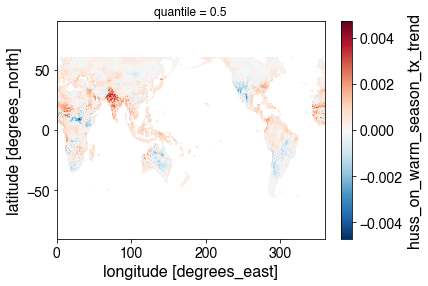

In [33]:
huss_on_tx_trend['huss_on_warm_season_tx_trend'][-10,:,:].plot()

In [16]:
tw = xr.open_dataset('era5_tw_warm_season_trends_by_decile.nc')
tw.load()
tw['tw_warm_season_trend'] = tw['tw_warm_season_trend'].sel(latitude=slice(60,-60))
tw['tw_warm_season_trend_p_value'] = tw['tw_warm_season_trend_p_value'].sel(latitude=slice(60,-60))

In [17]:
tx = xr.open_dataset('era5_tasmax_warm_season_trends_by_decile.nc')
tx.load()
tx['tasmax_warm_season_trend'] = tx['tasmax_warm_season_trend'].sel(latitude=slice(60,-60))
tx['tasmax_warm_season_trend_p_value'] = tx['tasmax_warm_season_trend_p_value'].sel(latitude=slice(60,-60))

In [18]:
tn = xr.open_dataset('era5_tasmin_trends_by_decile.nc')
tn.load()
tn['tasmin_trend'] = tn['tasmin_trend'].sel(latitude=slice(60,-60))
tn['tasmin_trend_p_value'] = tn['tasmin_trend_p_value'].sel(latitude=slice(60,-60))

In [38]:
sm_trends = xr.open_dataset('era5_sm_on_warm_season_tx_trends_by_decile.nc')
sm_trends.load()
sm_trends['sm_on_warm_season_tx_trend'] = sm_trends['sm_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
sm_trends['sm_on_warm_season_tx_p_value'] = sm_trends['sm_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

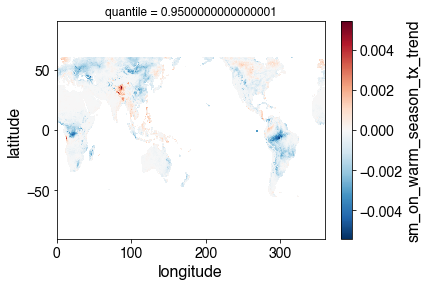

In [45]:
sm_trends['sm_on_warm_season_tx_trend'][-1,:,:].plot()

In [39]:
(sm_trends['sm_on_warm_season_tx_trend'].mean(dim=['latitude','longitude']) / sm_on_tx_deciles_mean.mean(dim=['latitude', 'longitude']) * 100).plot()

NameError: name 'sm_on_tx_deciles_mean' is not defined

In [30]:
p1 = 99
p2 = 50

tw_100_1d = tw.tw_warm_season_trend[p1,:,:].values.reshape(tw.tw_warm_season_trend[p1,:,:].size)
tw_100_p_1d = tw.tw_warm_season_trend_p_value[p1,:,:].values.reshape(tw.tw_warm_season_trend_p_value[p1,:,:].size)
# tw_100_1d = tw_100_1d[(tw_50_p_1d < .1) & (tw_100_p_1d < .1)]
tw_50_1d = tw.tw_warm_season_trend[p2,:,:].values.reshape(tw.tw_warm_season_trend[p2,:,:].size)
tw_50_p_1d = tw.tw_warm_season_trend_p_value[p1,:,:].values.reshape(tw.tw_warm_season_trend_p_value[p2,:,:].size)
# tw_50_1d = tw_50_1d[(tw_50_p_1d < .1) & (tw_100_p_1d < .1)]

tw_amp = tw.tw_warm_season_trend[p1,:,:]-tw.tw_warm_season_trend[p2,:,:]
tw_mean_1d = tw_era5_mean.tw.values.reshape(tw_era5_mean.tw.values.size)
tw_amp_1d = tw_amp.values.reshape(tw_amp.values.size)
# tw_amp_sig_1d = tw_amp_1d[np.where((tw_100_p_1d<0.05) & (tw_50_p_1d<0.05))[0]]


tx_100_1d = tx.tasmax_warm_season_trend[p1,:,:].values.reshape(tx.tasmax_warm_season_trend[p1,:,:].size)
tx_50_1d = tx.tasmax_warm_season_trend[p2,:,:].values.reshape(tx.tasmax_warm_season_trend[p2,:,:].size)
tx_amp = tx.tasmax_warm_season_trend[p1,:,:]-tx.tasmax_warm_season_trend[p2,:,:]
tx_mean_1d = tx_era5_mean.mx2t.values.reshape(tx_era5_mean.mx2t.values.size)
tx_amp_1d = tx_amp.values.reshape(tx_amp.values.size)


# tn_100_1d = tn.tasmin_trend[:,:,1].values.reshape(tn.tasmin_trend[:,:,1].size)
# tn_50_1d = tn.tasmin_trend[:,:,20].values.reshape(tn.tasmin_trend[:,:,20].size)
# tn_amp = tn.tasmin_trend[:,:,1]-tn.tasmin_trend[:,:,20]
# tn_mean_1d = tn_era5_mean.mn2t.values.reshape(tn_era5_mean.mn2t.values.size)
# tn_amp_1d = tn_amp.values.reshape(tn_amp.values.size)


sm_100_1d = sm_trends.sm_on_warm_season_tx_trend[-1,:,:].values.reshape(sm_trends.sm_on_warm_season_tx_trend[-1,:,:].size)
sm_50_1d = sm_trends.sm_on_warm_season_tx_trend[-10,:,:].values.reshape(sm_trends.sm_on_warm_season_tx_trend[-10,:,:].size)
sm_amp = sm_trends.sm_on_warm_season_tx_trend[-1,:,:]-sm_trends.sm_on_warm_season_tx_trend[-10,:,:]
sm_mean_1d = sm_on_tx_deciles_mean.values.reshape([sm_on_tx_deciles_mean.values.shape[0], sm_on_tx_deciles_mean.values.shape[1]*sm_on_tx_deciles_mean.values.shape[2]])
sm_amp_1d = sm_amp.values.reshape(sm_amp.values.size)



In [33]:
tx_amp.shape

(721, 1440)

In [34]:
sm_amp.shape

(360, 720)

In [31]:
nn = np.where((~np.isnan(tx_amp_1d)) & (~np.isnan(sm_amp_1d)))[0]
X = sm.add_constant(tx_amp_1d[nn])
mdl = sm.OLS(sm_amp_1d[nn], X).fit()
plt.scatter(tx_amp_1d, sm_amp_1d)
x1 = -.1
x2 = .1
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='slope=%.2f, r2=%.2f'%(mdl.params[1], mdl.rsquared))
plt.legend()


ValueError: operands could not be broadcast together with shapes (1038240,) (259200,) 

In [ ]:
nn = np.where((~np.isnan(tx_amp_1d)) & (~np.isnan(tw_amp_1d)))[0]
X = sm.add_constant(tx_amp_1d[nn])
mdl = sm.OLS(tw_amp_1d[nn], X).fit()
plt.scatter(tx_amp_1d, tw_amp_1d)
x1 = -.1
x2 = .1
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2)
# mdl.summary()

In [ ]:
tw_100_tmp_1d.shape

In [ ]:
land_pct_tw_amp = []
land_pct_tx_amp = []
land_pct_tn_amp = []

temp_bins = np.arange(-20, 41, 1)

for tw_mean_thresh in temp_bins:
    tw_100_tmp_1d = tw_100_1d.copy()
    tw_100_tmp_1d[(tw_mean_1d < tw_mean_thresh) | ((tw_mean_1d >= tw_mean_thresh+1))] = np.nan
#     tw_100_tmp_1d[tw_100_p_1d > 0.1] = np.nan
    
    tw_50_tmp_1d = tw_50_1d.copy()
    tw_50_tmp_1d[(tw_mean_1d < tw_mean_thresh) | ((tw_mean_1d >= tw_mean_thresh+1))] = np.nan
#     tw_50_tmp_1d[tw_50_p_1d > 0.1] = np.nan
    
    nn = np.where((~np.isnan(tw_100_tmp_1d)) & (~np.isnan(tw_50_tmp_1d)))[0]
    if nn.size > 10:
        land_pct_tw_amp.append(np.where(tw_100_tmp_1d[nn]>tw_50_tmp_1d[nn])[0].size/nn.size)
    else:
        land_pct_tw_amp.append(np.nan)
        
for tx_mean_thresh in temp_bins:
    tx_100_tmp_1d = tx_100_1d.copy()
    tx_100_tmp_1d[(tx_mean_1d < tx_mean_thresh) | ((tx_mean_1d >= tx_mean_thresh+1))] = np.nan
#     tx_100_tmp_1d[tx_100_p_1d > 0.1] = np.nan
    
    tx_50_tmp_1d = tx_50_1d.copy()
    tx_50_tmp_1d[(tx_mean_1d < tx_mean_thresh) | ((tx_mean_1d >= tx_mean_thresh+1))] = np.nan
#     tx_50_tmp_1d[tx_50_p_1d > 0.1] = np.nan
    
    nn = np.where((~np.isnan(tx_100_tmp_1d)) & (~np.isnan(tx_50_tmp_1d)))[0]
    if nn.size > 10:
        land_pct_tx_amp.append(np.where(tx_100_tmp_1d[nn]>tx_50_tmp_1d[nn])[0].size/nn.size)
    else:
        land_pct_tx_amp.append(np.nan)
        
        
        
# for tn_mean_thresh in temp_bins:
#     tn_100_tmp_1d = tn_100_1d.copy()
#     tn_100_tmp_1d[(tn_mean_1d < tn_mean_thresh) | ((tn_mean_1d >= tn_mean_thresh+1))] = np.nan
# #     tn_100_tmp_1d[tn_100_p_1d > 0.1] = np.nan
    
#     tn_50_tmp_1d = tn_50_1d.copy()
#     tn_50_tmp_1d[(tn_mean_1d < tn_mean_thresh) | ((tn_mean_1d >= tn_mean_thresh+1))] = np.nan
# #     tn_50_tmp_1d[tn_50_p_1d > 0.1] = np.nan
    
#     nn = np.where((~np.isnan(tn_100_tmp_1d)) & (~np.isnan(tn_50_tmp_1d)))[0]
#     if nn.size > 10:
#         land_pct_tn_amp.append(np.where(tn_100_tmp_1d[nn]>tn_50_tmp_1d[nn])[0].size/nn.size)
#     else:
#         land_pct_tn_amp.append(np.nan)

In [ ]:
plt.plot(temp_bins, land_pct_tw_amp)
plt.plot(temp_bins, land_pct_tx_amp)
# plt.plot(temp_bins, land_pct_tn_amp)

In [ ]:
nn = np.where((~np.isnan(tw_100_1d)) & (~np.isnan(tw_50_1d)))[0]
X = sm.add_constant(tw_50_1d[nn])
mdl = sm.OLS(tw_100_1d[nn], X).fit()

font = FontProperties(family='Arial', size=14)

x1 = np.nanmin(tw_50_1d)
x2 = np.nanmax(tw_50_1d)
plt.figure(figsize=(6,6))
plt.scatter(tw_50_1d[nn], tw_100_1d[nn], c=(tw_100_1d[nn]>tw_50_1d[nn]), cmap='bwr')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--w', label='slope = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
# plt.plot([x1,x2], [0,0], '-k', lw=2)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('TW %dth percentile trend'%p2)
plt.ylabel('TW %dth percentile trend'%p1)

In [ ]:
nn = np.where((~np.isnan(tx_100_1d)) & (~np.isnan(tx_50_1d)))[0]
X = sm.add_constant(tx_50_1d[nn])
mdl = sm.OLS(tx_100_1d[nn], X).fit()

font = FontProperties(family='Arial', size=14)

x1 = np.nanmin(tx_50_1d)
x2 = np.nanmax(tx_50_1d)
plt.figure(figsize=(6,6))
plt.scatter(tx_50_1d[nn], tx_100_1d[nn], c=(tx_100_1d[nn]>tx_50_1d[nn]), cmap='bwr')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--w', label='slope = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
# plt.plot([x1,x2], [0,0], '-k', lw=2)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('Tx %dth percentile trend'%p2)
plt.ylabel('Tx %dth percentile trend'%p1)

In [ ]:
nn = np.where((~np.isnan(tn_100_1d)) & (~np.isnan(tn_50_1d)))[0]
X = sm.add_constant(tn_50_1d[nn])
mdl = sm.OLS(tn_100_1d[nn], X).fit()

font = FontProperties(family='Arial', size=14)

x1 = np.nanmin(tn_50_1d)
x2 = np.nanmax(tn_50_1d)
plt.figure(figsize=(6,6))
plt.scatter(tn_50_1d[nn], tn_100_1d[nn], c=(tn_100_1d[nn]>tn_50_1d[nn]), cmap='bwr')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--w', label='slope = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
# plt.plot([x1,x2], [0,0], '-k', lw=2)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('Tn %dth percentile trend'%20)
plt.ylabel('Tn %dth percentile trend'%0)

In [ ]:
nn = np.where((~np.isnan(sm_100_1d)) & (~np.isnan(sm_50_1d)))[0]
X = sm.add_constant(sm_50_1d[nn])
mdl = sm.OLS(sm_100_1d[nn], X).fit()

font = FontProperties(family='Arial', size=14)

x1 = np.nanmin(sm_50_1d)
x2 = np.nanmax(sm_50_1d)
plt.figure(figsize=(6,6))
plt.scatter(sm_50_1d[nn], sm_100_1d[nn], c=tx_amp_1d[nn], cmap='bwr')#c=(sm_100_1d[nn]<sm_50_1d[nn]), cmap='bwr')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--w', label='slope = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
# plt.plot([x1,x2], [x1,x2], '-k', lw=3)
# plt.plot([x1,x2], [0,0], '-k', lw=2)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('sm on tx95 percentile trend')
plt.ylabel('sm on tx80 percentile trend')

In [ ]:
tw_amp_binary = tw_amp>0
tw_amp_land_only = tw_amp_binary.where(land_sea_mask_binary, np.nan)
tw_amp_land_only = tw_amp_land_only.where(~np.isnan(tw_amp), np.nan)
tw_amp_land_only = tw_amp_land_only.sel(latitude=slice(60,-60))
tw_amp_land_only.plot(cmap='bwr', figsize=(18,6))

In [ ]:
# result_array = xr.where((tx_amp > 0) & (tw_amp < 0), 1, 0)
tx_amp_binary = tx_amp>0
tx_amp_land_only = tx_amp_binary.where(land_sea_mask_binary, np.nan)
tx_amp_land_only = tx_amp_land_only.where(~np.isnan(tx_amp), np.nan)
tx_amp_land_only = tx_amp_land_only.sel(latitude=slice(60,-60))
tx_amp_land_only.plot(cmap='bwr', figsize=(18,6))

In [ ]:
tn_amp_binary = tn_amp>0
tn_amp_land_only = tn_amp_binary.where(land_sea_mask_binary, np.nan)
tn_amp_land_only = tn_amp_land_only.where(~np.isnan(tn_amp), np.nan)
tn_amp_land_only = tn_amp_land_only.sel(latitude=slice(60,-60))
tn_amp_land_only.plot(cmap='bwr', figsize=(18,6))

In [ ]:
sm_amp_binary = sm_amp<0
sm_amp_land_only = sm_amp_binary.where(land_sea_mask_binary, np.nan)
sm_amp_land_only = sm_amp_land_only.where(~np.isnan(sm_amp), np.nan)
sm_amp_land_only = sm_amp_land_only.sel(latitude=slice(60,-60))
sm_amp_land_only.plot(cmap='bwr', figsize=(18,6))

In [ ]:
tw_amp.plot(figsize=(18,10))